In [1]:
import os, copy
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import pandas as pd
import csv

DATA_PATH = os.getenv('HOME') + '/aiffel/object_detection/data'

In [2]:
(ds_train, ds_test), ds_info = tfds.load(
    'kitti',
    data_dir=DATA_PATH,
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

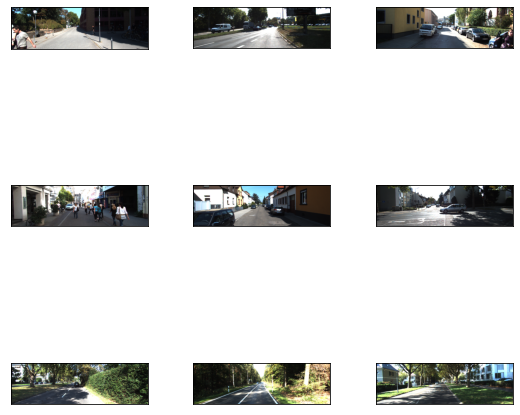

In [3]:
_ = tfds.show_examples(ds_train, ds_info)

In [4]:
ds_info

tfds.core.DatasetInfo(
    name='kitti',
    full_name='kitti/3.2.0',
    description="""
    Kitti contains a suite of vision tasks built using an autonomous driving
    platform. The full benchmark contains many tasks such as stereo, optical flow,
    visual odometry, etc. This dataset contains the object detection dataset,
    including the monocular images and bounding boxes. The dataset contains 7481
    training images annotated with 3D bounding boxes. A full description of the
    annotations can be found in the readme of the object development kit readme on
    the Kitti homepage.
    """,
    homepage='http://www.cvlibs.net/datasets/kitti/',
    data_path='/aiffel/aiffel/object_detection/data/kitti/3.2.0',
    download_size=11.71 GiB,
    dataset_size=5.27 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/file_name': Text(shape=(), dtype=tf.string),
        'objects': Sequence({
            'alpha': tf.float32,
     

------Example------
['image', 'image/file_name', 'objects']
------objects------
{'alpha': <tf.Tensor: shape=(4,), dtype=float32, numpy=array([-1.65, -0.91, -1.54, -1.55], dtype=float32)>, 'bbox': <tf.Tensor: shape=(4, 4), dtype=float32, numpy=
array([[0.3884    , 0.517657  , 0.62365335, 0.58592594],
       [0.31888   , 0.6498551 , 0.50130665, 0.7913526 ],
       [0.51512   , 0.43376812, 0.5657067 , 0.46615136],
       [0.52378666, 0.43924317, 0.62381333, 0.463905  ]], dtype=float32)>, 'dimensions': <tf.Tensor: shape=(4, 3), dtype=float32, numpy=
array([[2.48, 2.2 , 5.33],
       [1.37, 1.56, 4.19],
       [1.04, 2.23, 2.66],
       [2.37, 1.92, 4.43]], dtype=float32)>, 'location': <tf.Tensor: shape=(4, 3), dtype=float32, numpy=
array([[ 2.23,  1.62, 23.14],
       [ 6.65,  1.73, 16.82],
       [-2.96,  0.51, 41.81],
       [-3.26,  0.37, 48.33]], dtype=float32)>, 'occluded': <tf.Tensor: shape=(4,), dtype=int64, numpy=array([3, 1, 3, 3])>, 'rotation_y': <tf.Tensor: shape=(4,), dtype=flo

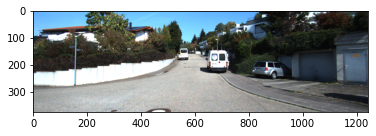

In [5]:
sample = ds_train.take(1)

for example in sample:  
    print('------Example------')
    print(list(example.keys()))
    image = example["image"]
    filename = example["image/file_name"].numpy().decode('utf-8')
    objects = example["objects"]

print('------objects------')
print(objects)

img = Image.fromarray(image.numpy())
plt.imshow(img)
plt.show()

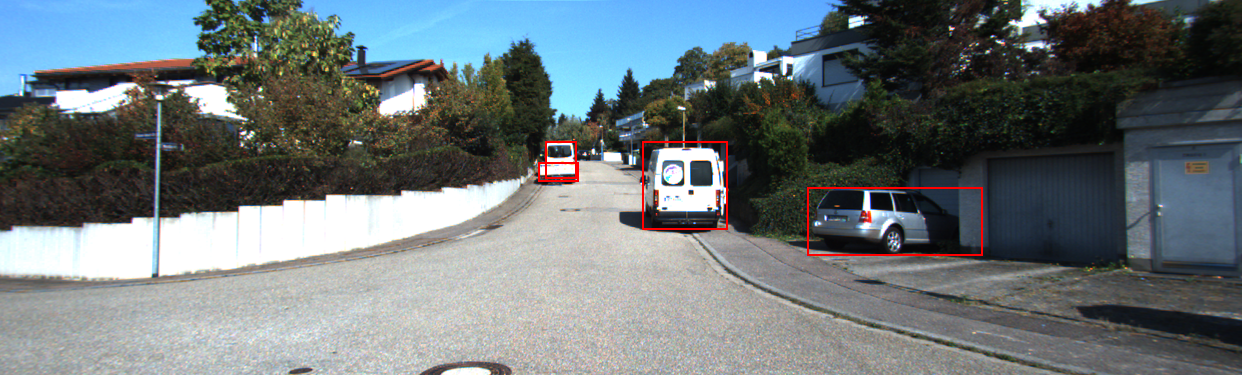

In [6]:
def visualize_bbox(input_image, object_bbox):
    input_image = copy.deepcopy(input_image)
    draw = ImageDraw.Draw(input_image)
    
    # 바운딩 박스 좌표(x_min, x_max, y_min, y_max) 구하기
    width, height = img.size
    x_min = object_bbox[:,1] * width
    x_max = object_bbox[:,3] * width
    y_min = height - object_bbox[:,0] * height
    y_max = height - object_bbox[:,2] * height
    
    # 바운딩 박스 그리기
    rects = np.stack([x_min, y_min, x_max, y_max], axis=1)
    for _rect in rects:
        draw.rectangle(_rect, outline=(255,0,0), width=2)

    return input_image

visualize_bbox(img, objects['bbox'].numpy())

In [7]:
def swap_xy(boxes):
    return tf.stack([boxes[:, 1], boxes[:, 0], boxes[:, 3], boxes[:, 2]], axis=-1)

In [8]:
def random_flip_horizontal(image, boxes):
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        boxes = tf.stack(
           [1 - boxes[:, 2], boxes[:, 1], 1 - boxes[:, 0], boxes[:, 3]], axis=-1
        )
        
    return image, boxes

In [9]:
def resize_and_pad_image(image, training=True):

    min_side = 800.0
    max_side = 1333.0
    min_side_range = [640, 1024]
    stride = 128.0
    
    image_shape = tf.cast(tf.shape(image)[:2], dtype=tf.float32)
    if training:
        min_side = tf.random.uniform((), min_side_range[0], min_side_range[1], dtype=tf.float32)
    ratio = min_side / tf.reduce_min(image_shape)
    if ratio * tf.reduce_max(image_shape) > max_side:
        ratio = max_side / tf.reduce_max(image_shape)
    image_shape = ratio * image_shape
    image = tf.image.resize(image, tf.cast(image_shape, dtype=tf.int32))
    padded_image_shape = tf.cast(
        tf.math.ceil(image_shape / stride) * stride, dtype=tf.int32
    )
    image = tf.image.pad_to_bounding_box(
        image, 0, 0, padded_image_shape[0], padded_image_shape[1]
    )
    return image, image_shape, ratio

In [10]:
def convert_to_xywh(boxes):
    return tf.concat(
        [(boxes[..., :2] + boxes[..., 2:]) / 2.0, boxes[..., 2:] - boxes[..., :2]],
        axis=-1,
    )

In [11]:
def preprocess_data(sample):
    image = sample["image"]
    bbox = swap_xy(sample["objects"]["bbox"])
    class_id = tf.cast(sample["objects"]["type"], dtype=tf.int32)

    image, bbox = random_flip_horizontal(image, bbox)
    image, image_shape, _ = resize_and_pad_image(image)

    bbox = tf.stack(
        [
            bbox[:, 0] * image_shape[1],
            bbox[:, 1] * image_shape[0],
            bbox[:, 2] * image_shape[1],
            bbox[:, 3] * image_shape[0],
        ],
        axis=-1,
    )
    bbox = convert_to_xywh(bbox)
    return image, bbox, class_id

In [12]:
class AnchorBox:
    def __init__(self):
        self.aspect_ratios = [0.5, 1.0, 2.0]
        self.scales = [2 ** x for x in [0, 1 / 3, 2 / 3]]

        self._num_anchors = len(self.aspect_ratios) * len(self.scales)
        self._strides = [2 ** i for i in range(3, 8)]
        self._areas = [x ** 2 for x in [32.0, 64.0, 128.0, 256.0, 512.0]]
        self._anchor_dims = self._compute_dims()

    def _compute_dims(self):
        anchor_dims_all = []
        for area in self._areas:
            anchor_dims = []
            for ratio in self.aspect_ratios:
                anchor_height = tf.math.sqrt(area / ratio)
                anchor_width = area / anchor_height
                dims = tf.reshape(
                    tf.stack([anchor_width, anchor_height], axis=-1), [1, 1, 2]
                )
                for scale in self.scales:
                    anchor_dims.append(scale * dims)
            anchor_dims_all.append(tf.stack(anchor_dims, axis=-2))
        return anchor_dims_all

    def _get_anchors(self, feature_height, feature_width, level):
        rx = tf.range(feature_width, dtype=tf.float32) + 0.5
        ry = tf.range(feature_height, dtype=tf.float32) + 0.5
        centers = tf.stack(tf.meshgrid(rx, ry), axis=-1) * self._strides[level - 3]
        centers = tf.expand_dims(centers, axis=-2)
        centers = tf.tile(centers, [1, 1, self._num_anchors, 1])
        dims = tf.tile(
            self._anchor_dims[level - 3], [feature_height, feature_width, 1, 1]
        )
        anchors = tf.concat([centers, dims], axis=-1)
        return tf.reshape(
            anchors, [feature_height * feature_width * self._num_anchors, 4]
        )

    def get_anchors(self, image_height, image_width):
        anchors = [
            self._get_anchors(
                tf.math.ceil(image_height / 2 ** i),
                tf.math.ceil(image_width / 2 ** i),
                i,
            )
            for i in range(3, 8)
        ]
        return tf.concat(anchors, axis=0)

In [13]:
def convert_to_corners(boxes):
    return tf.concat(
        [boxes[..., :2] - boxes[..., 2:] / 2.0, boxes[..., :2] + boxes[..., 2:] / 2.0],
        axis=-1,
    )

def compute_iou(boxes1, boxes2):
    boxes1_corners = convert_to_corners(boxes1)
    boxes2_corners = convert_to_corners(boxes2)
    lu = tf.maximum(boxes1_corners[:, None, :2], boxes2_corners[:, :2])
    rd = tf.minimum(boxes1_corners[:, None, 2:], boxes2_corners[:, 2:])
    intersection = tf.maximum(0.0, rd - lu)
    intersection_area = intersection[:, :, 0] * intersection[:, :, 1]
    boxes1_area = boxes1[:, 2] * boxes1[:, 3]
    boxes2_area = boxes2[:, 2] * boxes2[:, 3]
    union_area = tf.maximum(
        boxes1_area[:, None] + boxes2_area - intersection_area, 1e-8
    )
    return tf.clip_by_value(intersection_area / union_area, 0.0, 1.0)

In [14]:
class LabelEncoder:

    def __init__(self):
        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            [0.1, 0.1, 0.2, 0.2], dtype=tf.float32
        )

    def _match_anchor_boxes(
        self, anchor_boxes, gt_boxes, match_iou=0.5, ignore_iou=0.4
    ):
        iou_matrix = compute_iou(anchor_boxes, gt_boxes)
        max_iou = tf.reduce_max(iou_matrix, axis=1)
        matched_gt_idx = tf.argmax(iou_matrix, axis=1)
        positive_mask = tf.greater_equal(max_iou, match_iou)
        negative_mask = tf.less(max_iou, ignore_iou)
        ignore_mask = tf.logical_not(tf.logical_or(positive_mask, negative_mask))
        return (
            matched_gt_idx,
            tf.cast(positive_mask, dtype=tf.float32),
            tf.cast(ignore_mask, dtype=tf.float32),
        )

    def _compute_box_target(self, anchor_boxes, matched_gt_boxes):
        box_target = tf.concat(
            [
                (matched_gt_boxes[:, :2] - anchor_boxes[:, :2]) / anchor_boxes[:, 2:],
                tf.math.log(matched_gt_boxes[:, 2:] / anchor_boxes[:, 2:]),
            ],
            axis=-1,
        )
        box_target = box_target / self._box_variance
        return box_target

    def _encode_sample(self, image_shape, gt_boxes, cls_ids):
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        cls_ids = tf.cast(cls_ids, dtype=tf.float32)
        matched_gt_idx, positive_mask, ignore_mask = self._match_anchor_boxes(
            anchor_boxes, gt_boxes
        )
        matched_gt_boxes = tf.gather(gt_boxes, matched_gt_idx)
        box_target = self._compute_box_target(anchor_boxes, matched_gt_boxes)
        matched_gt_cls_ids = tf.gather(cls_ids, matched_gt_idx)
        cls_target = tf.where(
            tf.not_equal(positive_mask, 1.0), -1.0, matched_gt_cls_ids
        )
        cls_target = tf.where(tf.equal(ignore_mask, 1.0), -2.0, cls_target)
        cls_target = tf.expand_dims(cls_target, axis=-1)
        label = tf.concat([box_target, cls_target], axis=-1)
        return label

    def encode_batch(self, batch_images, gt_boxes, cls_ids):
        images_shape = tf.shape(batch_images)
        batch_size = images_shape[0]

        labels = tf.TensorArray(dtype=tf.float32, size=batch_size, dynamic_size=True)
        for i in range(batch_size):
            label = self._encode_sample(images_shape, gt_boxes[i], cls_ids[i])
            labels = labels.write(i, label)
        batch_images = tf.keras.applications.resnet.preprocess_input(batch_images)
        return batch_images, labels.stack()
    

In [15]:
class FeaturePyramid(tf.keras.layers.Layer):

    def __init__(self, backbone):
        super(FeaturePyramid, self).__init__(name="FeaturePyramid")
        self.backbone = backbone
        self.conv_c3_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c4_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c5_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c3_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c4_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c5_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c6_3x3 = tf.keras.layers.Conv2D(256, 3, 2, "same")
        self.conv_c7_3x3 = tf.keras.layers.Conv2D(256, 3, 2, "same")
        self.upsample_2x = tf.keras.layers.UpSampling2D(2)

    def call(self, images, training=False):
        c3_output, c4_output, c5_output = self.backbone(images, training=training)
        p3_output = self.conv_c3_1x1(c3_output)
        p4_output = self.conv_c4_1x1(c4_output)
        p5_output = self.conv_c5_1x1(c5_output)
        p4_output = p4_output + self.upsample_2x(p5_output)
        p3_output = p3_output + self.upsample_2x(p4_output)
        p3_output = self.conv_c3_3x3(p3_output)
        p4_output = self.conv_c4_3x3(p4_output)
        p5_output = self.conv_c5_3x3(p5_output)
        p6_output = self.conv_c6_3x3(c5_output)
        p7_output = self.conv_c7_3x3(tf.nn.relu(p6_output))
        return p3_output, p4_output, p5_output, p6_output, p7_output


In [16]:
def build_head(output_filters, bias_init):
    head = tf.keras.Sequential([tf.keras.Input(shape=[None, None, 256])])
    kernel_init = tf.initializers.RandomNormal(0.0, 0.01)
    for _ in range(4):
        head.add(
            tf.keras.layers.Conv2D(256, 3, padding="same", kernel_initializer=kernel_init)
        )
        head.add(tf.keras.layers.ReLU())
    head.add(
        tf.keras.layers.Conv2D(
            output_filters,
            3,
            1,
            padding="same",
            kernel_initializer=kernel_init,
            bias_initializer=bias_init,
        )
    )
    return head

In [17]:
def get_backbone():
    backbone = tf.keras.applications.ResNet50(
        include_top=False, input_shape=[None, None, 3]
    )
    c3_output, c4_output, c5_output = [
        backbone.get_layer(layer_name).output
        for layer_name in ["conv3_block4_out", "conv4_block6_out", "conv5_block3_out"]
    ]
    return tf.keras.Model(
        inputs=[backbone.inputs], outputs=[c3_output, c4_output, c5_output]
    )

In [18]:
class RetinaNet(tf.keras.Model):

    def __init__(self, num_classes, backbone):
        super(RetinaNet, self).__init__(name="RetinaNet")
        self.fpn = FeaturePyramid(backbone)
        self.num_classes = num_classes

        prior_probability = tf.constant_initializer(-np.log((1 - 0.01) / 0.01))
        self.cls_head = build_head(9 * num_classes, prior_probability)
        self.box_head = build_head(9 * 4, "zeros")

    def call(self, image, training=False):
        features = self.fpn(image, training=training)
        N = tf.shape(image)[0]
        cls_outputs = []
        box_outputs = []
        for feature in features:
            box_outputs.append(tf.reshape(self.box_head(feature), [N, -1, 4]))
            cls_outputs.append(
                tf.reshape(self.cls_head(feature), [N, -1, self.num_classes])
            )
        cls_outputs = tf.concat(cls_outputs, axis=1)
        box_outputs = tf.concat(box_outputs, axis=1)
        return tf.concat([box_outputs, cls_outputs], axis=-1)

In [19]:
class RetinaNetBoxLoss(tf.losses.Loss):

    def __init__(self, delta):
        super(RetinaNetBoxLoss, self).__init__(
            reduction="none", name="RetinaNetBoxLoss"
        )
        self._delta = delta

    def call(self, y_true, y_pred):
        difference = y_true - y_pred
        absolute_difference = tf.abs(difference)
        squared_difference = difference ** 2
        loss = tf.where(
            tf.less(absolute_difference, self._delta),
            0.5 * squared_difference,
            absolute_difference - 0.5,
        )
        return tf.reduce_sum(loss, axis=-1)


class RetinaNetClassificationLoss(tf.losses.Loss):

    def __init__(self, alpha, gamma):
        super(RetinaNetClassificationLoss, self).__init__(
            reduction="none", name="RetinaNetClassificationLoss"
        )
        self._alpha = alpha
        self._gamma = gamma

    def call(self, y_true, y_pred):
        cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=y_true, logits=y_pred
        )
        probs = tf.nn.sigmoid(y_pred)
        alpha = tf.where(tf.equal(y_true, 1.0), self._alpha, (1.0 - self._alpha))
        pt = tf.where(tf.equal(y_true, 1.0), probs, 1 - probs)
        loss = alpha * tf.pow(1.0 - pt, self._gamma) * cross_entropy
        return tf.reduce_sum(loss, axis=-1)


class RetinaNetLoss(tf.losses.Loss):

    def __init__(self, num_classes=8, alpha=0.25, gamma=2.0, delta=1.0):
        super(RetinaNetLoss, self).__init__(reduction="auto", name="RetinaNetLoss")
        self._clf_loss = RetinaNetClassificationLoss(alpha, gamma)
        self._box_loss = RetinaNetBoxLoss(delta)
        self._num_classes = num_classes

    def call(self, y_true, y_pred):
        y_pred = tf.cast(y_pred, dtype=tf.float32)
        box_labels = y_true[:, :, :4]
        box_predictions = y_pred[:, :, :4]
        cls_labels = tf.one_hot(
            tf.cast(y_true[:, :, 4], dtype=tf.int32),
            depth=self._num_classes,
            dtype=tf.float32,
        )
        cls_predictions = y_pred[:, :, 4:]
        positive_mask = tf.cast(tf.greater(y_true[:, :, 4], -1.0), dtype=tf.float32)
        ignore_mask = tf.cast(tf.equal(y_true[:, :, 4], -2.0), dtype=tf.float32)
        clf_loss = self._clf_loss(cls_labels, cls_predictions)
        box_loss = self._box_loss(box_labels, box_predictions)
        clf_loss = tf.where(tf.equal(ignore_mask, 1.0), 0.0, clf_loss)
        box_loss = tf.where(tf.equal(positive_mask, 1.0), box_loss, 0.0)
        normalizer = tf.reduce_sum(positive_mask, axis=-1)
        clf_loss = tf.math.divide_no_nan(tf.reduce_sum(clf_loss, axis=-1), normalizer)
        box_loss = tf.math.divide_no_nan(tf.reduce_sum(box_loss, axis=-1), normalizer)
        loss = clf_loss + box_loss
        return loss


In [20]:
num_classes = 8
batch_size = 2

resnet50_backbone = get_backbone()
loss_fn = RetinaNetLoss(num_classes)
model = RetinaNet(num_classes, resnet50_backbone)

94781440/94765736 [==============================] - 0s 0us/step


# custom metric 추가 -> 실패
- y_true, y_pred의 iou, precision, recall 등을 계산하는 metric을 만들어보려 했으나 실패함
- 주 원인은 y_true, y_pred의 bbox 값이 좌표값 or 정규화된 0~1값이 아니라 encoding된 값이라 decoding을 해야 하는데 여기서 실패
    - 혹은 위와 같이 파악한 것도 잘못된 것일 수 있음
- 배운 점 : metric 함수는 y_true, y_pred를 인자로 받고, return 값을 csv로 저장하는 방법을 알게 됨, IDE없이 cloud 환경에서 jupyter를 쓰는데 익숙해지고 있음.  
- 느낀 점 : 10시간을 여기 투자했는데, 헛발질만하고 배운 것이 없었다. 실력에 비해 과한 것을 도전하면 배우는게 너무 적음 -> 프로젝트는 기본적인 것만 하고 복습 위주로 해야겠음
- 아쉬웠던 점 : 주석을 걸어둔 함수에서 에러가 발생하여 해결하기가 정말 어려웠음
    - custom_iou 함수를 만듦 -> 에러남 -> 주석처리 -> 여전히 에러남 -> custom_iou_2로 변경 (주석 상태) -> 에러 안남 -> custom_iou로 변경 (주석 상태) -> 에러남 
    - 주석처리된 함수도 영향을 미칠 수 있다는 것을 알게됨. 물론 일반적인 케이스는 아닐 듯
    - cloud 용량을 꽉 채워버려서 추가 학습이 불가능했던 점

In [21]:
# y_true [2 135036 5] [batch_size, num_anchors, 바운딩 박스 좌표 4개와 클래스 라벨 1개]
# y_pred [2 135036 12] [batch_size, num_anchors, num_classes + 4] 
    # 각 앵커 박스에 대해 예측된 클래스 확률 (여기서는 클래스가 8개이므로 8)와 바운딩 박스 좌표 4개
def metric_print_shape(y_true, y_pred):
    tf.print("y_true shape:", tf.shape(y_true)[2])
    tf.print('y_true ', y_true[0,0,:])
    tf.print('y_true ', y_true[0,0,:4])
    tf.print("y_pred shape:", tf.shape(y_pred)[2]) 
    tf.print('y_pred ', y_pred[0,0,:])
    tf.print('y_pred ', y_pred[0,0,:4])
    tf.print('y_pred ', y_pred[0,0,4:8])
    tf.print('y_pred ', y_pred[0,0,8:])
    return 1

def calculate_iou(box1, box2):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.
    
    Parameters
    ----------
    box1 : tf.Tensor
        Tensor of shape (batch_size, anchor_num, 4) representing the first set of bounding boxes.
    box2 : tf.Tensor
        Tensor of shape (batch_size, anchor_num, 4) representing the second set of bounding boxes.
    
    Returns
    -------
    iou : tf.Tensor
        Tensor of shape (batch_size, anchor_num) representing the IoU for each pair of bounding boxes.
    """
    
    # Calculate the coordinates of the intersection rectangle
    x1 = tf.maximum(box1[..., 0], box2[..., 0])
    y1 = tf.maximum(box1[..., 1], box2[..., 1])
    x2 = tf.minimum(box1[..., 2], box2[..., 2])
    y2 = tf.minimum(box1[..., 3], box2[..., 3])
    
    # Calculate the area of the intersection rectangle
    intersection = tf.maximum(0.0, x2 - x1) * tf.maximum(0.0, y2 - y1)
    
    # Calculate the area of both bounding boxes
    box1_area = (box1[..., 2] - box1[..., 0]) * (box1[..., 3] - box1[..., 1])
    box2_area = (box2[..., 2] - box2[..., 0]) * (box2[..., 3] - box2[..., 1])
    
    # Calculate the union area
    union = box1_area + box2_area - intersection
    
    # Calculate the IoU
    iou = intersection / tf.maximum(union, 1e-8)
    
    return iou

def compute_iou_2(y_true, y_pred):
    tf.config.run_functions_eagerly(True)

    # y_true와 y_pred에서 바운딩 박스 좌표를 분리
    y_true_boxes_encoded = y_true[:, :, :4]
    y_pred_boxes_encoded = y_pred[:, :, :4]
    
    return calculate_iou(y_true_boxes_encoded, y_pred_boxes_encoded)

def compute_box_mse(y_true, y_pred):
    # y_true와 y_pred에서 바운딩 박스 좌표를 분리
    true_boxes = y_true[:, :, :4]
    pred_boxes = y_pred[:, :, :4]
    
    # 바운딩 박스 좌표의 평균 제곱 오차를 계산합니다.
    box_mse = tf.reduce_mean(tf.square(true_boxes - pred_boxes))
        
    # 두 손실을 결합하여 최종 메트릭을 계산합니다.
    return box_mse

def compute_class_ce(y_true, y_pred):
    # y_true에서 바운딩 박스 좌표와 클래스 라벨을 분리합니다.
    true_boxes = y_true[:, :, :4]
    true_classes = tf.cast(y_true[:, :, 4], dtype=tf.int32)  # 클래스 라벨을 정수형으로 변환
    
    # y_pred에서 바운딩 박스 좌표와 클래스 확률을 분리합니다.
    pred_boxes = y_pred[:, :, :4]
    pred_classes = y_pred[:, :, 4:]
        
    # 클래스 확률의 크로스 엔트로피 손실을 계산합니다.
    class_ce = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=true_classes, logits=pred_classes))
    
    # 두 손실을 결합하여 최종 메트릭을 계산합니다.
    return class_ce


In [22]:
# 학습률
learning_rates = [2.5e-06, 0.000625, 0.00125, 0.0025, 0.00025, 2.5e-05]
# 125 iter, 250 iter...단계에 위 학습률이 적용됨
learning_rate_boundaries = [125, 250, 500, 240000, 360000]
learning_rate_fn = tf.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=learning_rate_boundaries, values=learning_rates
)
optimizer = tf.optimizers.SGD(learning_rate=learning_rate_fn, momentum=0.9)
# model.compile(loss=loss_fn, optimizer=optimizer)

# metric 추가
# 박스 위치 손실:모델이 예측한 바운딩 박스 좌표와 실제 바운딩 박스 좌표 간의 차이를 측정
model.compile(
    loss=loss_fn,
    optimizer=optimizer,
    metrics=[
        tf.keras.metrics.CategoricalAccuracy(), # 정확도
#         metric_print_shape,
        compute_iou_2,
        compute_box_mse,
        compute_class_ce
    ]
)

In [23]:
label_encoder = LabelEncoder()
(train_dataset, val_dataset), dataset_info = tfds.load(
    "kitti", split=["train", "validation"], with_info=True, data_dir=DATA_PATH
)

autotune = tf.data.AUTOTUNE
train_dataset = train_dataset.map(preprocess_data, num_parallel_calls=autotune)
train_dataset = train_dataset.shuffle(8 * batch_size)
train_dataset = train_dataset.padded_batch(
    batch_size=batch_size, padding_values=(0.0, 1e-8, -1), drop_remainder=True
)
train_dataset = train_dataset.map(
    label_encoder.encode_batch, num_parallel_calls=autotune
)
train_dataset = train_dataset.prefetch(autotune)

val_dataset = val_dataset.map(preprocess_data, num_parallel_calls=autotune)
val_dataset = val_dataset.padded_batch(
    batch_size=1, padding_values=(0.0, 1e-8, -1), drop_remainder=True
)
val_dataset = val_dataset.map(label_encoder.encode_batch, num_parallel_calls=autotune)
val_dataset = val_dataset.prefetch(autotune)

# loss, metric 저장 기능 추가
- model 가중치, loss, metric을 특정 iteration마다 저장하는 코드 추가
- f.keras.callbacks.CSVLogger 사용시 주의 사항
    - append를 False로 하면, model.fit이 시작될 때마다 새로운 로그 파일이 생성되고 첫 번째 에포크에서 기존 로그 파일이 덮어쓰여집니다. 따라서, 이전에 저장된 로그 데이터는 새로운 훈련 세션이 시작되면서 사라집니다
    - 따라서 append=True로 하되, 같은 epoch의 정보가 append되면 정리해줘야함
    - 여기서는 사용 안 함 (custom 기능 사용)
- 코드를 반복해서 돌리면 model의 가중치가 초기화되지 않기 때문에 주의해야 함

In [24]:
# class CustomLoggingCallback(tf.keras.callbacks.Callback):
#     def __init__(self, log_dir, interval=100, val_data=None):
#         super().__init__()
#         self.log_dir = log_dir
#         self.interval = interval
#         self.iteration = 0
#         self.val_data = val_data
#         self.csv_file = os.path.join(log_dir, "training_log.csv")
        
#         # CSV 파일에 헤더 작성
#         if not os.path.exists(self.csv_file):
#             with open(self.csv_file, mode='w', newline='') as f:
#                 writer = csv.writer(f)
#                 writer.writerow(["iteration", "loss", "val_loss", "accuracy", "iou", "box_mse", "class_ce", "learning_rate"])

#     def on_train_batch_end(self, batch, logs=None):
#         self.iteration += 1
#         if self.iteration % self.interval == 0:
#             loss = logs.get("loss")
#             lr = self.model.optimizer._decayed_lr(tf.float32).numpy()  # 현재 학습률 가져오기
#             accuracy = logs.get("categorical_accuracy")
#             iou = logs.get("compute_iou_2")
#             box_mse = logs.get("compute_box_mse")
#             class_ce = logs.get("compute_class_ce")
            
#             val_loss = ""
#             if self.val_data is not None:
#                 val_logs = self.model.evaluate(self.val_data, verbose=0)
#                 val_loss = val_logs[0]  # Assuming the first metric is loss
                
#             with open(self.csv_file, mode='a', newline='') as f:  # 'a' 모드로 파일을 열어 데이터 추가
#                 writer = csv.writer(f)
#                 writer.writerow([self.iteration, loss, val_loss, accuracy, iou, box_mse, class_ce, lr])
# #             print(f"Iteration {self.iteration}: loss = {loss}, val_loss = {val_loss}, lr = {lr}, accuracy = {accuracy}, iou = {iou}, box_mse = {box_mse}, class_ce = {class_ce}")

#     def on_epoch_end(self, epoch, logs=None):
#         val_loss = logs.get("val_loss")
#         accuracy = logs.get("categorical_accuracy")
#         iou = logs.get("compute_iou_2")
#         box_mse = logs.get("compute_box_mse")
#         class_ce = logs.get("compute_class_ce")
#         lr = self.model.optimizer._decayed_lr(tf.float32).numpy()
#         with open(self.csv_file, mode='a', newline='') as f:
#             writer = csv.writer(f)
#             writer.writerow(["epoch_end", "", val_loss, accuracy, iou, box_mse, class_ce, lr])
#         print(f"Epoch {epoch + 1}: val_loss = {val_loss}, accuracy = {accuracy}, iou = {iou}, box_mse = {box_mse}, class_ce = {class_ce}, lr = {lr}")


In [25]:
# class CustomLoggingCallback(tf.keras.callbacks.Callback):
#     def __init__(self, log_dir, interval=100, val_data=None):
#         super(CustomLoggingCallback, self).__init__()
#         self.log_dir = log_dir
#         self.interval = interval
#         self.iteration = 0
#         self.epoch = 0
#         self.val_data = val_data
#         self.csv_file = os.path.join(log_dir, "training_log.csv")
        
#         # CSV 파일에 헤더 작성
#         if not os.path.exists(self.csv_file):
#             with open(self.csv_file, mode='w', newline='') as f:
#                 writer = csv.writer(f)
#                 writer.writerow(["epoch", "iteration", "loss", "val_loss", "accuracy", "iou", "box_mse", "class_ce", "learning_rate"])

#     def on_epoch_begin(self, epoch, logs=None):
#         self.epoch = epoch

#     def on_train_batch_end(self, batch, logs=None):
#         self.iteration += 1
#         if self.iteration % self.interval == 0:
#             loss = logs.get("loss")
#             lr = self.model.optimizer._decayed_lr(tf.float32).numpy()  # 현재 학습률 가져오기
#             accuracy = logs.get("categorical_accuracy")
#             iou = logs.get("compute_iou_2")
#             box_mse = logs.get("compute_box_mse")
#             class_ce = logs.get("compute_class_ce")
            
#             val_loss = ""
#             if self.val_data is not None:
#                 val_logs = self.model.evaluate(self.val_data, verbose=0)
#                 val_loss = val_logs[0]  # Assuming the first metric is loss
                
#             with open(self.csv_file, mode='a', newline='') as f:  # 'a' 모드로 파일을 열어 데이터 추가
#                 writer = csv.writer(f)
#                 writer.writerow([self.epoch, self.iteration, loss, val_loss, accuracy, iou, box_mse, class_ce, lr])
#             print(f"Epoch {self.epoch}, Iteration {self.iteration}: loss = {loss}, val_loss = {val_loss}, lr = {lr}, accuracy = {accuracy}, iou = {iou}, box_mse = {box_mse}, class_ce = {class_ce}")

#     def on_epoch_end(self, epoch, logs=None):
#         val_loss = logs.get("val_loss")
#         accuracy = logs.get("categorical_accuracy")
#         iou = logs.get("compute_iou_2")
#         box_mse = logs.get("compute_box_mse")
#         class_ce = logs.get("compute_class_ce")
#         lr = self.model.optimizer._decayed_lr(tf.float32).numpy()
#         with open(self.csv_file, mode='a', newline='') as f:
#             writer = csv.writer(f)
#             writer.writerow([epoch, "epoch_end", "", val_loss, accuracy, iou, box_mse, class_ce, lr])
#         print(f"Epoch {epoch + 1}: val_loss = {val_loss}, accuracy = {accuracy}, iou = {iou}, box_mse = {box_mse}, class_ce = {class_ce}, lr = {lr}")


In [26]:
class CustomLoggingCallback(tf.keras.callbacks.Callback):
    def __init__(self, log_dir, interval=100, val_data=None):
        super(CustomLoggingCallback, self).__init__()
        self.log_dir = log_dir
        self.interval = interval
        self.iteration = 0
        self.epoch = 0
        self.val_data = val_data
        self.csv_file = os.path.join(log_dir, "training_log.csv")
        
        # CSV 파일에 헤더 작성
        if not os.path.exists(self.csv_file):
            with open(self.csv_file, mode='w', newline='') as f:
                writer = csv.writer(f)
                writer.writerow(["epoch", "iteration", "loss", "val_loss", "accuracy", "iou", "box_mse", "class_ce", "learning_rate"])

    def on_epoch_begin(self, epoch, logs=None):
        self.epoch = epoch

    def on_train_batch_end(self, batch, logs=None):
        self.iteration += 1
        if self.iteration % self.interval == 0:
            loss = logs.get("loss")
            lr = self.model.optimizer._decayed_lr(tf.float32).numpy()  # 현재 학습률 가져오기
            accuracy = logs.get("categorical_accuracy")
            iou = logs.get("compute_iou_2")
            box_mse = logs.get("compute_box_mse")
            class_ce = logs.get("compute_class_ce")
            
            val_loss = ""
            if self.val_data is not None:
                val_logs = self.model.evaluate(self.val_data, verbose=0)
                val_loss = val_logs[0]  # Assuming the first metric is loss

            # CSV 파일 불러오기
            if os.path.exists(self.csv_file):
                df = pd.read_csv(self.csv_file)
            else:
                df = pd.DataFrame(columns=["epoch", "iteration", "loss", "val_loss", "accuracy", "iou", "box_mse", "class_ce", "learning_rate"])
            
            # 같은 epoch와 iteration을 가진 행이 있으면 업데이트, 없으면 추가
            if not ((df['epoch'] == self.epoch) & (df['iteration'] == self.iteration)).any():
                new_row = {"epoch": self.epoch, "iteration": self.iteration, "loss": loss, "val_loss": val_loss, "accuracy": accuracy, "iou": iou, "box_mse": box_mse, "class_ce": class_ce, "learning_rate": lr}
                df = df.append(new_row, ignore_index=True)
            else:
                df.loc[(df['epoch'] == self.epoch) & (df['iteration'] == self.iteration), ['loss', 'val_loss', 'accuracy', 'iou', 'box_mse', 'class_ce', 'learning_rate']] = [loss, val_loss, accuracy, iou, box_mse, class_ce, lr]
            
            # CSV 파일에 저장
            df.to_csv(self.csv_file, index=False)
            print(f"Epoch {self.epoch}, Iteration {self.iteration}: loss = {loss}, val_loss = {val_loss}, lr = {lr}, accuracy = {accuracy}, iou = {iou}, box_mse = {box_mse}, class_ce = {class_ce}")

    def on_epoch_end(self, epoch, logs=None):
        val_loss = logs.get("val_loss")
        accuracy = logs.get("categorical_accuracy")
        iou = logs.get("compute_iou_2")
        box_mse = logs.get("compute_box_mse")
        class_ce = logs.get("compute_class_ce")
        lr = self.model.optimizer._decayed_lr(tf.float32).numpy()

        # CSV 파일 불러오기
        if os.path.exists(self.csv_file):
            df = pd.read_csv(self.csv_file)
        else:
            df = pd.DataFrame(columns=["epoch", "iteration", "loss", "val_loss", "accuracy", "iou", "box_mse", "class_ce", "learning_rate"])
        
        # 같은 epoch와 'epoch_end' iteration을 가진 행이 있으면 업데이트, 없으면 추가
        if not ((df['epoch'] == epoch) & (df['iteration'] == 'epoch_end')).any():
            new_row = {"epoch": epoch, "iteration": "epoch_end", "loss": "", "val_loss": val_loss, "accuracy": accuracy, "iou": iou, "box_mse": box_mse, "class_ce": class_ce, "learning_rate": lr}
            df = df.append(new_row, ignore_index=True)
        else:
            df.loc[(df['epoch'] == epoch) & (df['iteration'] == 'epoch_end'), ['val_loss', 'accuracy', 'iou', 'box_mse', 'class_ce', 'learning_rate']] = [val_loss, accuracy, iou, box_mse, class_ce, lr]

        # CSV 파일에 저장
        df.to_csv(self.csv_file, index=False)
        print(f"Epoch {epoch + 1}: val_loss = {val_loss}, accuracy = {accuracy}, iou = {iou}, box_mse = {box_mse}, class_ce = {class_ce}, lr = {lr}")


In [27]:
class CustomModelCheckpoint(tf.keras.callbacks.Callback):
    def __init__(self, model_dir, interval=100):
        super(CustomModelCheckpoint, self).__init__()
        self.model_dir = model_dir
        self.interval = interval
        self.iteration = 0
        self.epoch = 0

    def on_epoch_begin(self, epoch, logs=None):
        self.epoch = epoch

    def on_train_batch_end(self, batch, logs=None):
        self.iteration += 1
        if self.iteration % self.interval == 0:
            filepath = os.path.join(self.model_dir, f"weights_epoch_{self.epoch}_iter_{self.iteration}")
            self.model.save_weights(filepath)
            print(f"Saved model weights at epoch {self.epoch}, iteration {self.iteration}")


In [28]:
model_dir = os.getenv('HOME') + '/aiffel/object_detection/data/trn_checkpoints/'
log_dir = os.getenv('HOME') + '/aiffel/object_detection/data/logs/'

os.makedirs(model_dir, exist_ok=True)
os.makedirs(log_dir, exist_ok=True)


In [ ]:
# 커스텀 콜백 인스턴스 생성
custom_logging_callback = CustomLoggingCallback(log_dir=log_dir, interval=100)
# 커스텀 Checkpoint 인스턴스 생성
custom_model_checkpoint = CustomModelCheckpoint(model_dir=model_dir, interval=100)

callbacks_list = [
    custom_logging_callback,   # 커스텀 로그 콜백 추가
    custom_model_checkpoint    # 커스텀 모델 체크포인트 콜백 추가
]

epochs = 30

model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=callbacks_list
)

Epoch 1/30
 100/3173 [..............................] - ETA: 32:40 - loss: 3.8741 - categorical_accuracy: 0.2640 - compute_iou_2: 7.6087e-08 - compute_box_mse: 4492.8164 - compute_class_ce: nanEpoch 0, Iteration 100: loss = 3.874108076095581, val_loss = , lr = 2.499999936844688e-06, accuracy = 0.26404932141304016, iou = 7.608650776091963e-08, box_mse = 4492.81640625, class_ce = nan
Saved model weights at epoch 0, iteration 100
 200/3173 [>.............................] - ETA: 32:30 - loss: 3.8601 - categorical_accuracy: 0.2718 - compute_iou_2: 5.7965e-08 - compute_box_mse: 4437.6392 - compute_class_ce: nanEpoch 0, Iteration 200: loss = 3.8601083755493164, val_loss = , lr = 0.0006249999860301614, accuracy = 0.27179354429244995, iou = 5.796501412191901e-08, box_mse = 4437.63916015625, class_ce = nan
Saved model weights at epoch 0, iteration 200
 300/3173 [=>............................] - ETA: 31:40 - loss: 3.7642 - categorical_accuracy: 0.2807 - compute_iou_2: 1.0437e-07 - compute_box_m

 627/3173 [====>.........................] - ETA: 26:52 - loss: 1.1418 - categorical_accuracy: 0.2562 - compute_iou_2: 1.5557e-04 - compute_box_mse: 4378.4194 - compute_class_ce: nanEpoch 1, Iteration 3800: loss = 1.141842246055603, val_loss = , lr = 0.0024999999441206455, accuracy = 0.25616705417633057, iou = 0.00015556789003312588, box_mse = 4378.41943359375, class_ce = nan
Saved model weights at epoch 1, iteration 3800
 727/3173 [=====>........................] - ETA: 25:48 - loss: 1.1307 - categorical_accuracy: 0.2561 - compute_iou_2: 1.5407e-04 - compute_box_mse: 4369.0708 - compute_class_ce: nanEpoch 1, Iteration 3900: loss = 1.1307129859924316, val_loss = , lr = 0.0024999999441206455, accuracy = 0.25605812668800354, iou = 0.0001540686353109777, box_mse = 4369.07080078125, class_ce = nan
Saved model weights at epoch 1, iteration 3900
 827/3173 [======>.......................] - ETA: 24:45 - loss: 1.1362 - categorical_accuracy: 0.2576 - compute_iou_2: 1.5483e-04 - compute_box_mse:

1354/3173 [===========>..................] - ETA: 19:14 - loss: 0.7788 - categorical_accuracy: 0.2462 - compute_iou_2: 1.8966e-04 - compute_box_mse: 4377.1021 - compute_class_ce: nanEpoch 2, Iteration 7700: loss = 0.7787546515464783, val_loss = , lr = 0.0024999999441206455, accuracy = 0.24621881544589996, iou = 0.0001896557951113209, box_mse = 4377.10205078125, class_ce = nan
Saved model weights at epoch 2, iteration 7700
1454/3173 [============>.................] - ETA: 18:11 - loss: 0.7772 - categorical_accuracy: 0.2474 - compute_iou_2: 1.8924e-04 - compute_box_mse: 4374.6753 - compute_class_ce: nanEpoch 2, Iteration 7800: loss = 0.7772222757339478, val_loss = , lr = 0.0024999999441206455, accuracy = 0.24736781418323517, iou = 0.00018924142932519317, box_mse = 4374.67529296875, class_ce = nan
Saved model weights at epoch 2, iteration 7800
1554/3173 [=============>................] - ETA: 17:07 - loss: 0.7708 - categorical_accuracy: 0.2460 - compute_iou_2: 1.9154e-04 - compute_box_mse

1881/3173 [================>.............] - ETA: 13:36 - loss: 0.6013 - categorical_accuracy: 0.2376 - compute_iou_2: 2.1742e-04 - compute_box_mse: 4353.4482 - compute_class_ce: nanEpoch 3, Iteration 11400: loss = 0.6012704372406006, val_loss = , lr = 0.0024999999441206455, accuracy = 0.23764607310295105, iou = 0.00021742498211096972, box_mse = 4353.4482421875, class_ce = nan
Saved model weights at epoch 3, iteration 11400
1981/3173 [=================>............] - ETA: 12:32 - loss: 0.5991 - categorical_accuracy: 0.2372 - compute_iou_2: 2.1721e-04 - compute_box_mse: 4357.5366 - compute_class_ce: nanEpoch 3, Iteration 11500: loss = 0.5991065502166748, val_loss = , lr = 0.0024999999441206455, accuracy = 0.23717154562473297, iou = 0.00021720744553022087, box_mse = 4357.53662109375, class_ce = nan
Saved model weights at epoch 3, iteration 11500
2081/3173 [==================>...........] - ETA: 11:29 - loss: 0.5958 - categorical_accuracy: 0.2370 - compute_iou_2: 2.1821e-04 - compute_box

 508/3173 [===>..........................] - ETA: 28:18 - loss: 0.5119 - categorical_accuracy: 0.2169 - compute_iou_2: 2.4042e-04 - compute_box_mse: 4408.4199 - compute_class_ce: nanEpoch 4, Iteration 13200: loss = 0.5119479894638062, val_loss = , lr = 0.0024999999441206455, accuracy = 0.21692852675914764, iou = 0.00024042045697569847, box_mse = 4408.419921875, class_ce = nan
Saved model weights at epoch 4, iteration 13200
 608/3173 [====>.........................] - ETA: 27:14 - loss: 0.5128 - categorical_accuracy: 0.2196 - compute_iou_2: 2.3978e-04 - compute_box_mse: 4380.0850 - compute_class_ce: nanEpoch 4, Iteration 13300: loss = 0.5127648115158081, val_loss = , lr = 0.0024999999441206455, accuracy = 0.21958161890506744, iou = 0.00023977793171070516, box_mse = 4380.0849609375, class_ce = nan
Saved model weights at epoch 4, iteration 13300
 708/3173 [=====>........................] - ETA: 26:10 - loss: 0.5137 - categorical_accuracy: 0.2200 - compute_iou_2: 2.3527e-04 - compute_box_m

1035/3173 [========>.....................] - ETA: 22:32 - loss: 0.4390 - categorical_accuracy: 0.2302 - compute_iou_2: 2.5609e-04 - compute_box_mse: 4374.3555 - compute_class_ce: nanEpoch 5, Iteration 16900: loss = 0.43896058201789856, val_loss = , lr = 0.0024999999441206455, accuracy = 0.230171799659729, iou = 0.0002560868742875755, box_mse = 4374.35546875, class_ce = nan
Saved model weights at epoch 5, iteration 16900
1135/3173 [=========>....................] - ETA: 21:29 - loss: 0.4371 - categorical_accuracy: 0.2296 - compute_iou_2: 2.5819e-04 - compute_box_mse: 4374.1543 - compute_class_ce: nanEpoch 5, Iteration 17000: loss = 0.4370594620704651, val_loss = , lr = 0.0024999999441206455, accuracy = 0.22955887019634247, iou = 0.0002581917797215283, box_mse = 4374.154296875, class_ce = nan
Saved model weights at epoch 5, iteration 17000
1235/3173 [==========>...................] - ETA: 20:25 - loss: 0.4319 - categorical_accuracy: 0.2302 - compute_iou_2: 2.5672e-04 - compute_box_mse: 4

1562/3173 [=============>................] - ETA: 17:02 - loss: 0.3660 - categorical_accuracy: 0.2309 - compute_iou_2: 2.7317e-04 - compute_box_mse: 4376.3218 - compute_class_ce: nanEpoch 6, Iteration 20600: loss = 0.3660176396369934, val_loss = , lr = 0.0024999999441206455, accuracy = 0.2309441864490509, iou = 0.00027317472267895937, box_mse = 4376.32177734375, class_ce = nan
Saved model weights at epoch 6, iteration 20600
1662/3173 [==============>...............] - ETA: 15:59 - loss: 0.3646 - categorical_accuracy: 0.2295 - compute_iou_2: 2.7305e-04 - compute_box_mse: 4362.5972 - compute_class_ce: nanEpoch 6, Iteration 20700: loss = 0.36459794640541077, val_loss = , lr = 0.0024999999441206455, accuracy = 0.229497030377388, iou = 0.00027305149706080556, box_mse = 4362.59716796875, class_ce = nan
Saved model weights at epoch 6, iteration 20700
1762/3173 [===============>..............] - ETA: 14:55 - loss: 0.3621 - categorical_accuracy: 0.2287 - compute_iou_2: 2.7361e-04 - compute_box_

2089/3173 [==================>...........] - ETA: 11:30 - loss: 0.3081 - categorical_accuracy: 0.2206 - compute_iou_2: 2.9863e-04 - compute_box_mse: 4355.8345 - compute_class_ce: nanEpoch 7, Iteration 24300: loss = 0.30813953280448914, val_loss = , lr = 0.0024999999441206455, accuracy = 0.2206220030784607, iou = 0.00029863123199902475, box_mse = 4355.83447265625, class_ce = nan
Saved model weights at epoch 7, iteration 24300
2189/3173 [===================>..........] - ETA: 10:26 - loss: 0.3081 - categorical_accuracy: 0.2207 - compute_iou_2: 2.9776e-04 - compute_box_mse: 4349.1987 - compute_class_ce: nanEpoch 7, Iteration 24400: loss = 0.3081381916999817, val_loss = , lr = 0.0024999999441206455, accuracy = 0.22067643702030182, iou = 0.0002977639378514141, box_mse = 4349.19873046875, class_ce = nan
Saved model weights at epoch 7, iteration 24400
2289/3173 [====================>.........] - ETA: 9:22 - loss: 0.3068 - categorical_accuracy: 0.2209 - compute_iou_2: 2.9909e-04 - compute_box_

 716/3173 [=====>........................] - ETA: 25:54 - loss: 0.2845 - categorical_accuracy: 0.2355 - compute_iou_2: 2.9329e-04 - compute_box_mse: 4382.5703 - compute_class_ce: nanEpoch 8, Iteration 26100: loss = 0.28448960185050964, val_loss = , lr = 0.0024999999441206455, accuracy = 0.23552437126636505, iou = 0.0002932921051979065, box_mse = 4382.5703125, class_ce = nan
Saved model weights at epoch 8, iteration 26100
 816/3173 [======>.......................] - ETA: 24:50 - loss: 0.2842 - categorical_accuracy: 0.2370 - compute_iou_2: 2.9371e-04 - compute_box_mse: 4384.2173 - compute_class_ce: nanEpoch 8, Iteration 26200: loss = 0.2842225730419159, val_loss = , lr = 0.0024999999441206455, accuracy = 0.2370348572731018, iou = 0.000293713848805055, box_mse = 4384.21728515625, class_ce = nan
Saved model weights at epoch 8, iteration 26200
 916/3173 [=======>......................] - ETA: 23:46 - loss: 0.2835 - categorical_accuracy: 0.2364 - compute_iou_2: 2.9640e-04 - compute_box_mse: 

1243/3173 [==========>...................] - ETA: 20:34 - loss: 0.2427 - categorical_accuracy: 0.2244 - compute_iou_2: 3.0319e-04 - compute_box_mse: 4370.3262 - compute_class_ce: nanEpoch 9, Iteration 29800: loss = 0.24268172681331635, val_loss = , lr = 0.0024999999441206455, accuracy = 0.22442300617694855, iou = 0.0003031914820894599, box_mse = 4370.326171875, class_ce = nan
Saved model weights at epoch 9, iteration 29800
1343/3173 [===========>..................] - ETA: 19:30 - loss: 0.2424 - categorical_accuracy: 0.2250 - compute_iou_2: 3.0310e-04 - compute_box_mse: 4370.1577 - compute_class_ce: nanEpoch 9, Iteration 29900: loss = 0.2424219399690628, val_loss = , lr = 0.0024999999441206455, accuracy = 0.22497718036174774, iou = 0.0003030999796465039, box_mse = 4370.15771484375, class_ce = nan
Saved model weights at epoch 9, iteration 29900
1443/3173 [============>.................] - ETA: 18:27 - loss: 0.2424 - categorical_accuracy: 0.2252 - compute_iou_2: 3.0146e-04 - compute_box_m

Saved model weights at epoch 10, iteration 33400
1770/3173 [===============>..............] - ETA: 14:53 - loss: 0.2086 - categorical_accuracy: 0.2174 - compute_iou_2: 3.2687e-04 - compute_box_mse: 4352.1855 - compute_class_ce: nanEpoch 10, Iteration 33500: loss = 0.2086077779531479, val_loss = , lr = 0.0024999999441206455, accuracy = 0.2174128293991089, iou = 0.0003268687869422138, box_mse = 4352.185546875, class_ce = nan
Saved model weights at epoch 10, iteration 33500
1870/3173 [================>.............] - ETA: 13:50 - loss: 0.2088 - categorical_accuracy: 0.2179 - compute_iou_2: 3.2670e-04 - compute_box_mse: 4350.3999 - compute_class_ce: nanEpoch 10, Iteration 33600: loss = 0.20875424146652222, val_loss = , lr = 0.0024999999441206455, accuracy = 0.2179138958454132, iou = 0.0003266954736318439, box_mse = 4350.39990234375, class_ce = nan
Saved model weights at epoch 10, iteration 33600
1970/3173 [=================>............] - ETA: 12:46 - loss: 0.2075 - categorical_accuracy:

Saved model weights at epoch 11, iteration 35200
 397/3173 [==>...........................] - ETA: 29:16 - loss: 0.1959 - categorical_accuracy: 0.2159 - compute_iou_2: 3.2363e-04 - compute_box_mse: 4436.1499 - compute_class_ce: nanEpoch 11, Iteration 35300: loss = 0.19590508937835693, val_loss = , lr = 0.0024999999441206455, accuracy = 0.21591760218143463, iou = 0.00032362539786845446, box_mse = 4436.14990234375, class_ce = nan
Saved model weights at epoch 11, iteration 35300
 497/3173 [===>..........................] - ETA: 28:13 - loss: 0.1945 - categorical_accuracy: 0.2148 - compute_iou_2: 3.2424e-04 - compute_box_mse: 4421.6133 - compute_class_ce: nanEpoch 11, Iteration 35400: loss = 0.1945013701915741, val_loss = , lr = 0.0024999999441206455, accuracy = 0.21482354402542114, iou = 0.00032424370874650776, box_mse = 4421.61328125, class_ce = nan
Saved model weights at epoch 11, iteration 35400
 597/3173 [====>.........................] - ETA: 27:09 - loss: 0.1973 - categorical_accura

2297/3173 [====================>.........] - ETA: 9:14 - loss: 0.1860 - categorical_accuracy: 0.2267 - compute_iou_2: 3.3231e-04 - compute_box_mse: 4359.0918 - compute_class_ce: nanEpoch 11, Iteration 37200: loss = 0.1860080510377884, val_loss = , lr = 0.0024999999441206455, accuracy = 0.22674666345119476, iou = 0.0003323137352708727, box_mse = 4359.091796875, class_ce = nan
Saved model weights at epoch 11, iteration 37200
2397/3173 [=====================>........] - ETA: 8:11 - loss: 0.1870 - categorical_accuracy: 0.2275 - compute_iou_2: 3.3359e-04 - compute_box_mse: 4364.2729 - compute_class_ce: nanEpoch 11, Iteration 37300: loss = 0.1869594007730484, val_loss = , lr = 0.0024999999441206455, accuracy = 0.22752244770526886, iou = 0.00033359412918798625, box_mse = 4364.27294921875, class_ce = nan
Saved model weights at epoch 11, iteration 37300
2497/3173 [======================>.......] - ETA: 7:07 - loss: 0.1861 - categorical_accuracy: 0.2282 - compute_iou_2: 3.3145e-04 - compute_box_

# 학습 중간에 끊기면, 이어하기

In [36]:
latest_checkpoint = tf.train.latest_checkpoint(model_dir)
print(latest_checkpoint)
initial_epoch = 0

if latest_checkpoint:
    print(f"Restoring model from checkpoint: {latest_checkpoint}")
    model.load_weights(latest_checkpoint)
    initial_epoch = int(latest_checkpoint.split('_epoch_')[-1].split('.')[0][:2])
    print(initial_epoch)
    

/aiffel/aiffel/object_detection/data/trn_checkpoints/weights_epoch_11_iter_36500
Restoring model from checkpoint: /aiffel/aiffel/object_detection/data/trn_checkpoints/weights_epoch_11_iter_36500
11


In [37]:
# 커스텀 콜백 인스턴스 생성
custom_logging_callback = CustomLoggingCallback(log_dir=log_dir, interval=100)
# 커스텀 Checkpoint 인스턴스 생성
custom_model_checkpoint = CustomModelCheckpoint(model_dir=model_dir, interval=100)

callbacks_list = [
    custom_logging_callback,   # 커스텀 로그 콜백 추가
    custom_model_checkpoint    # 커스텀 모델 체크포인트 콜백 추가
]

total_epochs = 30

model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=total_epochs,
    initial_epoch=initial_epoch,
    callbacks=callbacks_list
)

Epoch 12/30
 100/3173 [..............................] - ETA: 31:41 - loss: 0.1991 - categorical_accuracy: 0.2294 - compute_iou_2: 3.5879e-04 - compute_box_mse: 4496.4019 - compute_class_ce: nanEpoch 11, Iteration 100: loss = 0.19908744096755981, val_loss = , lr = 0.0024999999441206455, accuracy = 0.2294294536113739, iou = 0.00035878978087566793, box_mse = 4496.40185546875, class_ce = nan
Saved model weights at epoch 11, iteration 100
 200/3173 [>.............................] - ETA: 31:23 - loss: 0.1945 - categorical_accuracy: 0.2326 - compute_iou_2: 3.6722e-04 - compute_box_mse: 4492.0586 - compute_class_ce: nanEpoch 11, Iteration 200: loss = 0.19452983140945435, val_loss = , lr = 0.0024999999441206455, accuracy = 0.23262402415275574, iou = 0.0003672166494652629, box_mse = 4492.05859375, class_ce = nan
Saved model weights at epoch 11, iteration 200
 300/3173 [=>............................] - ETA: 30:27 - loss: 0.1797 - categorical_accuracy: 0.2310 - compute_iou_2: 3.5138e-04 - compu

KeyboardInterrupt: 

# 시각화

In [ ]:
log_file=os.path.join(log_dir, "training_log.csv")

# CSV 파일 읽기
log_data = pd.read_csv(log_file)

# 데이터프레임 확인
print(log_data.head())

# 손실 값 시각화
plt.figure(figsize=(10, 5))
plt.plot(log_data['epoch'], log_data['loss'], label='Training Loss')
plt.plot(log_data['epoch'], log_data['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [ ]:
model_dir = os.getenv('HOME') + '/aiffel/object_detection/data/checkpoints/'
latest_checkpoint = tf.train.latest_checkpoint(model_dir)
model.load_weights(latest_checkpoint)

In [ ]:
class DecodePredictions(tf.keras.layers.Layer):

    def __init__(
        self,
        num_classes=8,
        confidence_threshold=0.05,
        nms_iou_threshold=0.5,
        max_detections_per_class=100,
        max_detections=100,
        box_variance=[0.1, 0.1, 0.2, 0.2]
    ):
        super(DecodePredictions, self).__init__()
        self.num_classes = num_classes
        self.confidence_threshold = confidence_threshold
        self.nms_iou_threshold = nms_iou_threshold
        self.max_detections_per_class = max_detections_per_class
        self.max_detections = max_detections

        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            box_variance, dtype=tf.float32
        )

    def _decode_box_predictions(self, anchor_boxes, box_predictions):
        boxes = box_predictions * self._box_variance
        boxes = tf.concat(
            [
                boxes[:, :, :2] * anchor_boxes[:, :, 2:] + anchor_boxes[:, :, :2],
                tf.math.exp(boxes[:, :, 2:]) * anchor_boxes[:, :, 2:],
            ],
            axis=-1,
        )
        boxes_transformed = convert_to_corners(boxes)
        return boxes_transformed

    def call(self, images, predictions):
        image_shape = tf.cast(tf.shape(images), dtype=tf.float32)
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        box_predictions = predictions[:, :, :4]
        cls_predictions = tf.nn.sigmoid(predictions[:, :, 4:])
        boxes = self._decode_box_predictions(anchor_boxes[None, ...], box_predictions)

        return tf.image.combined_non_max_suppression(
            tf.expand_dims(boxes, axis=2),
            cls_predictions,
            self.max_detections_per_class,
            self.max_detections,
            self.nms_iou_threshold,
            self.confidence_threshold,
            clip_boxes=False,
        )

In [ ]:
image = tf.keras.Input(shape=[None, None, 3], name="image")
predictions = model(image, training=False)
detections = DecodePredictions(confidence_threshold=0.5)(image, predictions)
inference_model = tf.keras.Model(inputs=image, outputs=detections)

In [ ]:
def visualize_detections(
    image, boxes, classes, scores, figsize=(7, 7), linewidth=1, color=[0, 0, 1]
):
    image = np.array(image, dtype=np.uint8)
    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.imshow(image)
    ax = plt.gca()
    for box, _cls, score in zip(boxes, classes, scores):
        text = "{}: {:.2f}".format(_cls, score)
        x1, y1, x2, y2 = box
        origin_x, origin_y = x1, image.shape[0] - y2 # matplitlib에서 Rectangle와 text를 그릴 때는 좌하단이 원점이고 위로 갈 수록 y값이 커집니다
        w, h = x2 - x1, y2 - y1
        patch = plt.Rectangle(
            [origin_x, origin_y], w, h, fill=False, edgecolor=color, linewidth=linewidth
        )
        ax.add_patch(patch)
        ax.text(
            origin_x,
            origin_y,
            text,
            bbox={"facecolor": color, "alpha": 0.4},
            clip_box=ax.clipbox,
            clip_on=True,
        )
    plt.show()
    return ax

In [ ]:
def prepare_image(image):
    image, _, ratio = resize_and_pad_image(image, training=False)
    image = tf.keras.applications.resnet.preprocess_input(image)
    return tf.expand_dims(image, axis=0), ratio

In [ ]:
test_dataset = tfds.load("kitti", split="test", data_dir=DATA_PATH)
int2str = dataset_info.features["objects"]["type"].int2str

for sample in test_dataset.take(2):
    image = tf.cast(sample["image"], dtype=tf.float32)
    input_image, ratio = prepare_image(image)
    detections = inference_model.predict(input_image)
    num_detections = detections.valid_detections[0]
    class_names = [
        int2str(int(x)) for x in detections.nmsed_classes[0][:num_detections]
    ]
    visualize_detections(
        image,
        detections.nmsed_boxes[0][:num_detections] / ratio,
        class_names,
        detections.nmsed_scores[0][:num_detections],
    )

coarse-grained, pre~f1~ 
iter마다의 metric -> 정량적 평가
이미지에 box 올리는건 정성적 평가 
metric : box 위치 loss, iou loss, class loss (accuracy, precision, recall)
샘플 개수 늘려서도 시도 
평가 할 꺼 부터 하기 

In [ ]:
RetinaNetLoss 문서 보고 반환하는거 찾기 
predict 에 더미 넣어서 tensor 보고
shift+tab
model.